In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/gru-model/anu_model.joblib
/kaggle/input/implementation-py/gru_model.joblib
/kaggle/input/implementation-py/__results__.html
/kaggle/input/implementation-py/__notebook__.ipynb
/kaggle/input/implementation-py/__output__.json
/kaggle/input/implementation-py/custom.css
/kaggle/input/implementation-py/__results___files/__results___1_2.png
/kaggle/input/implementation-py/__results___files/__results___3_1.png
/kaggle/input/terrestrial-data/TER20.csv
/kaggle/input/anu-model/ANU_model.h5
/kaggle/input/satellite-dataset/SAT20.csv
/kaggle/input/stin-dataset/SAT20.csv


/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


   fl_dur  fw_pk  l_fw_pkt  l_bw_pkt  pkt_len_min  pkt_len_max  pkt_len_std  \
0       1      2         0         0            0            0          0.0   
1       1      2         0         0            0            0          0.0   
2       0      2         0         0            0            0          0.0   
3       1      2         0         0            0            0          0.0   
4       1      2         0         0            0            0          0.0   

   fl_byt_s  fl_iat_min  bw_iat_tot  ...  down_up_ratio  fw_byt_blk_avg  \
0       0.0           1           0  ...              0               0   
1       0.0           1           0  ...              0               0   
2       0.0           0           0  ...              0               0   
3       0.0           1           0  ...              0               0   
4       0.0           1           0  ...              0               0   

   fw_pkt_blk_avg  fw_blk_rate_avg  bw_byt_blk_avg  bw_pkt_blk_avg  \
0   

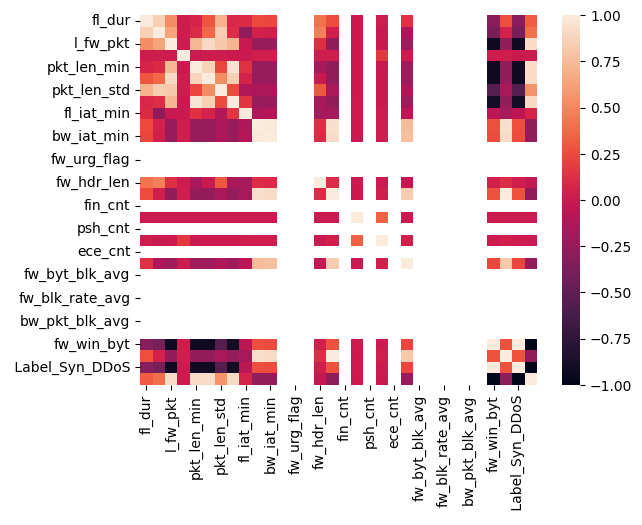

In [2]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd


df = pd.read_csv("../input/satellite-dataset/SAT20.csv")
df=df.dropna()
df = df.drop('id', axis=1)
print(df.head())
dfs = pd.get_dummies(df, columns=[' Label'])
correlation_matrix = dfs.corr(method='spearman')
#correlation_matrix.style.background_gradient(cmap='coolwarm')
#print(correlation_matrix)
sns.heatmap(correlation_matrix)
plt.show()
#plt.savefig('cor.png', bbox_inches='tight')



In [54]:
#integrating data cleaning, feature extraction, data preprocessing

import pandas as pd
from mlxtend.feature_selection import SequentialFeatureSelector as SFS
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import LabelEncoder

from sklearn.model_selection import train_test_split

import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam

# Data preparation
df_sat = pd.read_csv("../input/satellite-dataset/SAT20.csv")
df_ter = pd.read_csv("../input/terrestrial-data/TER20.csv")

frames = [df_sat, df_ter]
df_concat = pd.concat(frames)
df_concat.drop(columns='id', inplace=True)

print(df_concat.head())
print(df_concat.shape)

# sample the dataset for easier debugging
# df_concat = df_concat.sample(n=100)

# These columns give problems with NaNs after normalizing
df_concat = df_concat.drop(columns=['syn_cnt', 'urg_cnt', 'bw_psh_flag', 'fw_urg_flag', 'bw_urg_flag', 'fin_cnt', 'psh_cnt', 'ece_cnt', 'fw_byt_blk_avg', 'fw_pkt_blk_avg', 'fw_blk_rate_avg', 'bw_byt_blk_avg', 'bw_pkt_blk_avg', 'bw_blk_rate_avg'])
print(df_concat.head())

# Minority removal (merge data)
labels = {
    'Syn_DDoS': 'Syn_DDoS',
    'UDP_DDoS': 'UDP_DDoS',
    'Botnet': 'Botnet',
    'Portmap_DDoS': 'DDoS',
    'Backdoor': 'Botnet',
    'Web Attack': 'Botnet',
    'LDAP_DDoS': 'DDoS',
    'MSSQL_DDoS': 'DDoS',
    'NetBIOS_DDoS': 'DDoS'
}
df_concat[' Label'] = df_concat[' Label'].map(labels)
print(df_concat[' Label'].value_counts())

# Extract the label column
y = df_concat[' Label']
df_concat.drop(columns=' Label', inplace=True)
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

# Print the mapping of original labels to encoded integers
label_mapping = dict(zip(label_encoder.classes_, label_encoder.transform(label_encoder.classes_)))
print("Label mapping:", label_mapping)

# min max normalize
normalized_df=(df_concat-df_concat.min())/(df_concat.max()-df_concat.min())
print(normalized_df.head())

X = normalized_df

sfs = SFS(RandomForestClassifier(max_depth=2, random_state=0),
          k_features=10,
          forward=True,
          floating=False,
          scoring = 'accuracy',
          cv = 0)
sfs.fit(X,y_encoded)
print(sfs.k_feature_names_)

X = X[np.array(sfs.k_feature_names_)]

   fl_dur  fw_pk  l_fw_pkt  l_bw_pkt  pkt_len_min  pkt_len_max  pkt_len_std  \
0       1      2         0         0            0            0          0.0   
1       1      2         0         0            0            0          0.0   
2       0      2         0         0            0            0          0.0   
3       1      2         0         0            0            0          0.0   
4       1      2         0         0            0            0          0.0   

   fl_byt_s  fl_iat_min  bw_iat_tot  ...  down_up_ratio  fw_byt_blk_avg  \
0       0.0           1           0  ...              0               0   
1       0.0           1           0  ...              0               0   
2       0.0           0           0  ...              0               0   
3       0.0           1           0  ...              0               0   
4       0.0           1           0  ...              0               0   

   fw_pkt_blk_avg  fw_blk_rate_avg  bw_byt_blk_avg  bw_pkt_blk_avg  \
0   

/opt/conda/lib/python3.10/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


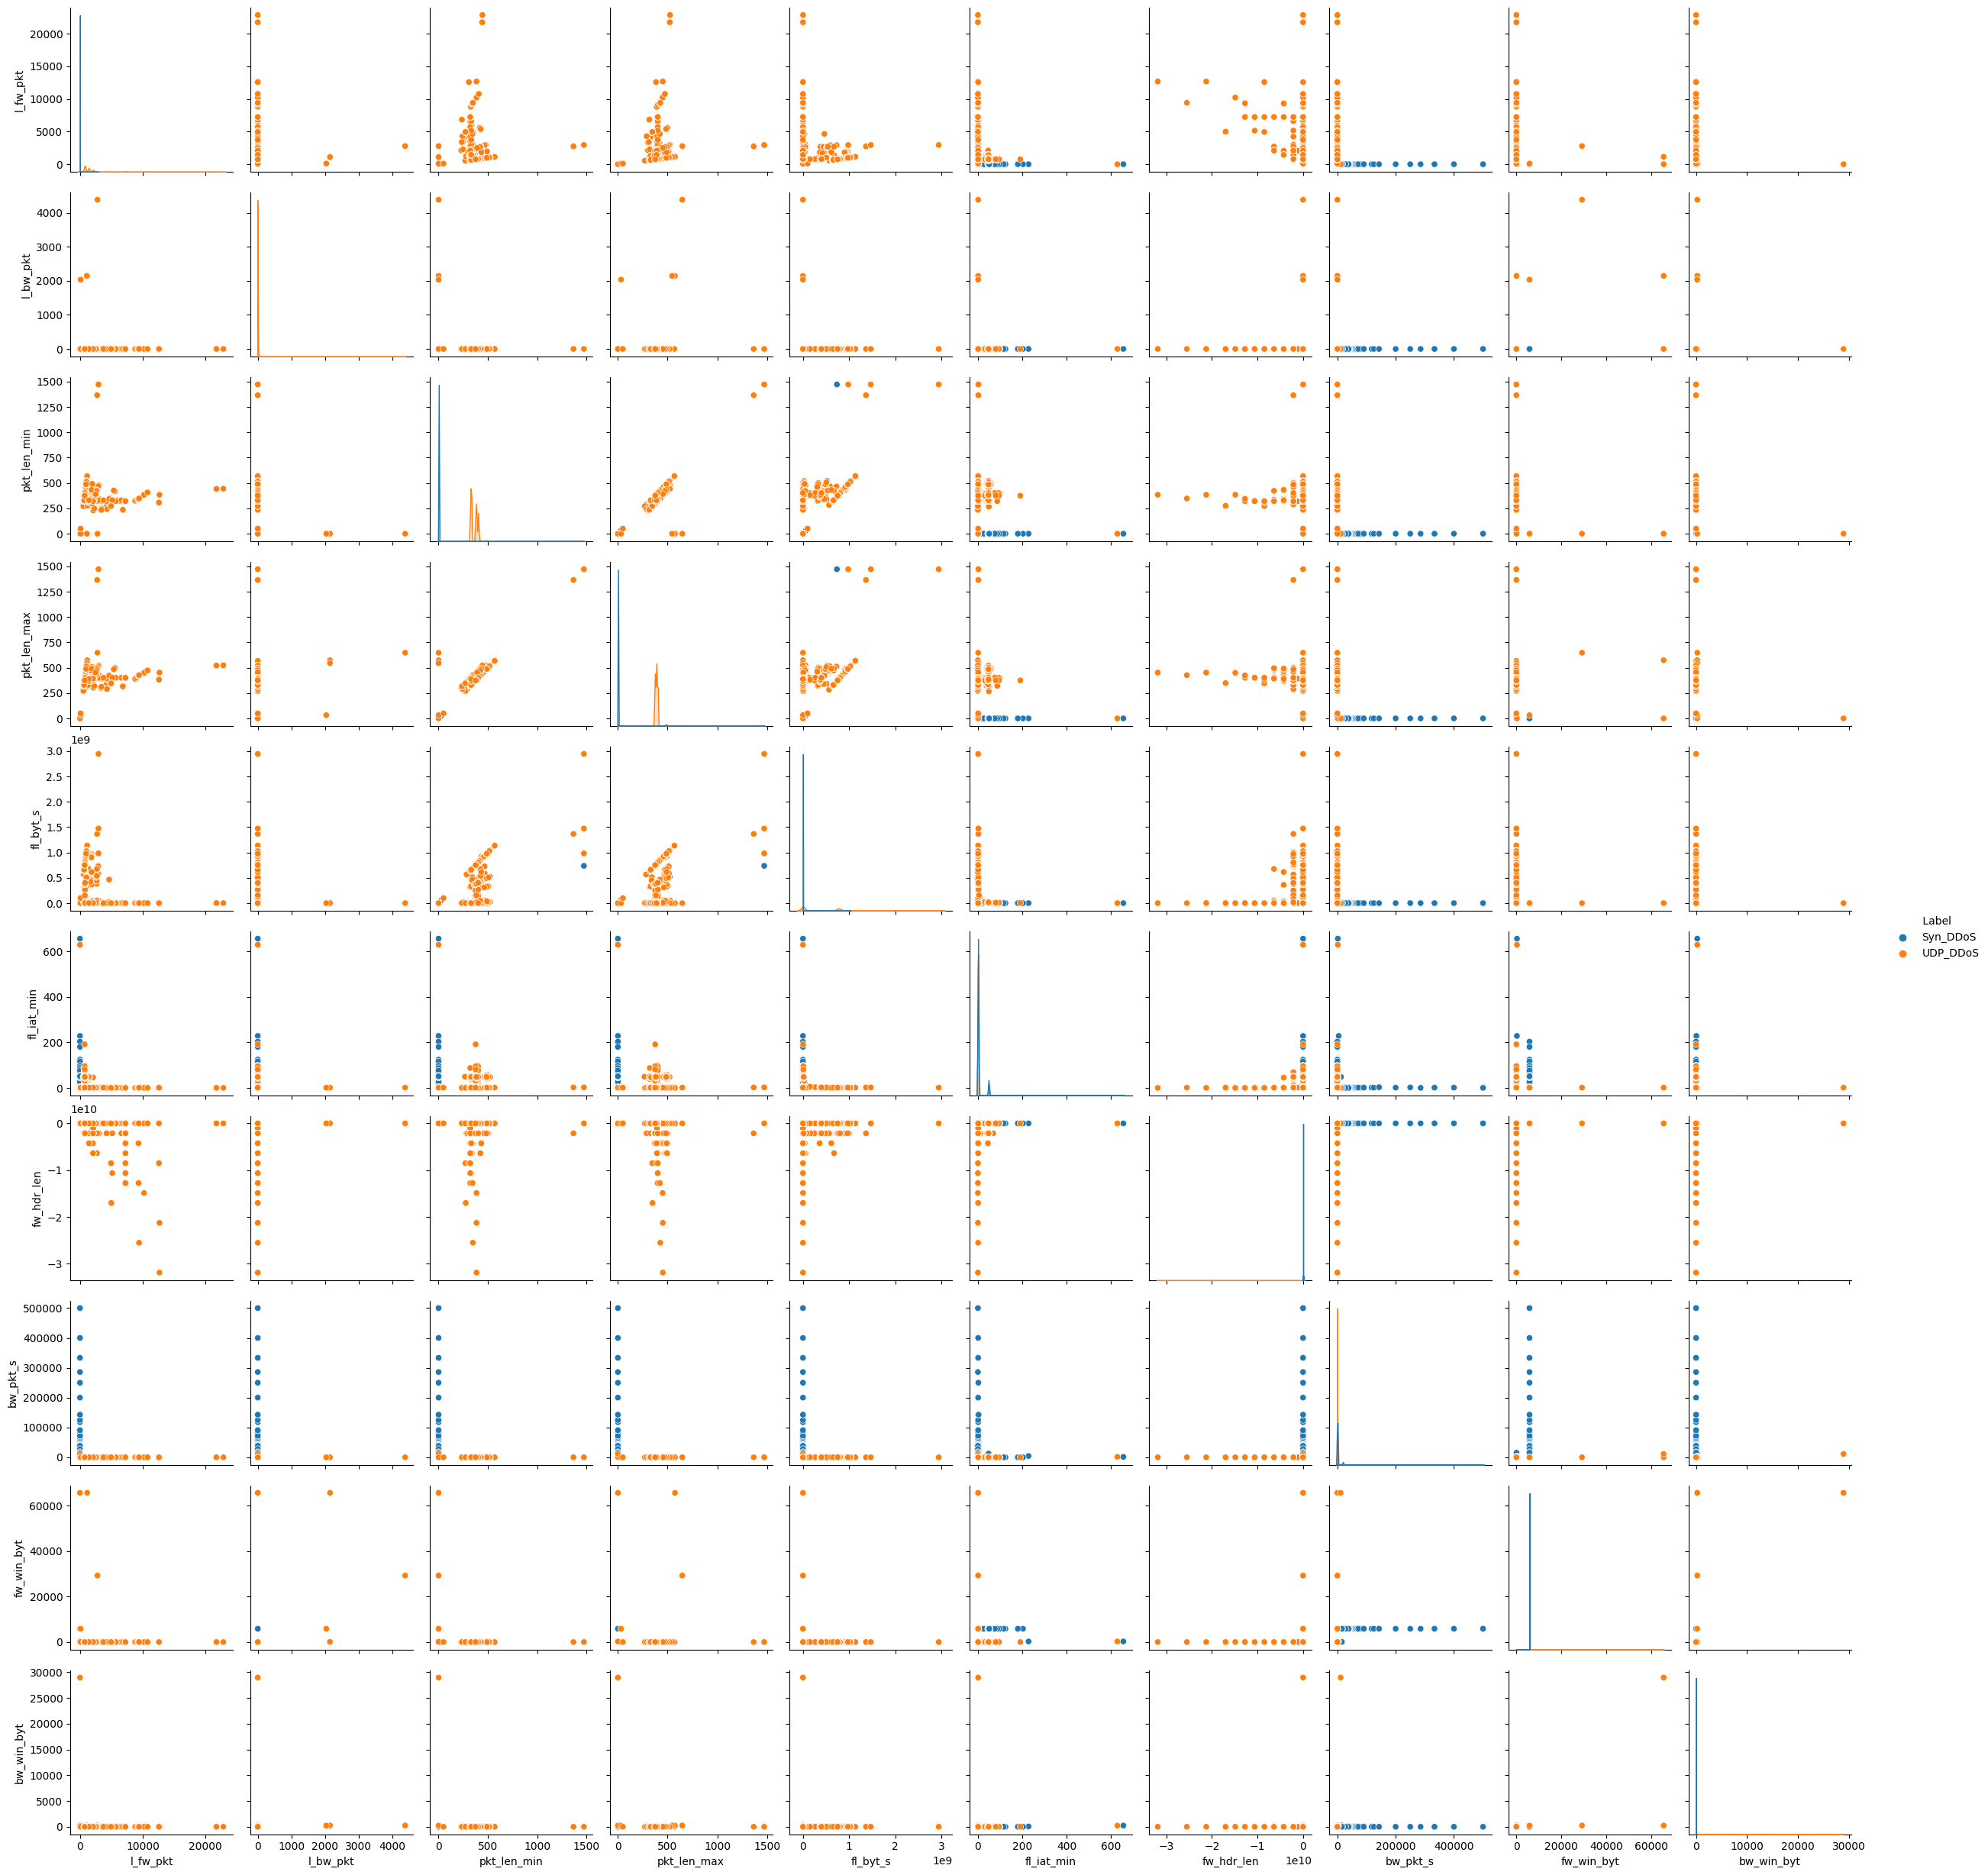

In [5]:
features = df[['l_fw_pkt', 'l_bw_pkt', 'pkt_len_min', 'pkt_len_max', 'fl_byt_s', 'fl_iat_min', 'fw_hdr_len', 'bw_pkt_s', 'fw_win_byt', 'bw_win_byt',' Label']]
sns.pairplot(features, hue = ' Label')
plt.show()

In [59]:
# Data preparation
sat = pd.read_csv("../input/satellite-dataset/SAT20.csv")
ter = pd.read_csv("../input/terrestrial-data/TER20.csv")

frames = [sat, ter]
df_con = pd.concat(frames)
df_con.drop(columns='id', inplace=True)

print(df_concat.head())
print(df_concat.shape)

# sample the dataset for easier debugging
# df_concat = df_concat.sample(n=100)

# These columns give problems with NaNs after normalizing
df_con = df_con.drop(columns=['syn_cnt', 'urg_cnt', 'bw_psh_flag', 'fw_urg_flag', 'bw_urg_flag', 'fin_cnt', 'psh_cnt', 'ece_cnt', 'fw_byt_blk_avg', 'fw_pkt_blk_avg', 'fw_blk_rate_avg', 'bw_byt_blk_avg', 'bw_pkt_blk_avg', 'bw_blk_rate_avg'])
print(df_con.head())

# Minority removal (merge data)
labels = {
    'Syn_DDoS': 'Syn_DDoS',
    'UDP_DDoS': 'UDP_DDoS',
    'Botnet': 'Botnet',
    'Portmap_DDoS': 'DDoS',
    'Backdoor': 'Botnet',
    'Web Attack': 'Botnet',
    'LDAP_DDoS': 'DDoS',
    'MSSQL_DDoS': 'DDoS',
    'NetBIOS_DDoS': 'DDoS'
}
df_con[' Label'] = df_con[' Label'].map(labels)

   fl_dur  fw_pk  l_fw_pkt  l_bw_pkt  pkt_len_min  pkt_len_max  pkt_len_std  \
0       1      2         0         0            0            0          0.0   
1       1      2         0         0            0            0          0.0   
2       0      2         0         0            0            0          0.0   
3       1      2         0         0            0            0          0.0   
4       1      2         0         0            0            0          0.0   

   fl_byt_s  fl_iat_min  bw_iat_tot  bw_iat_min  fw_hdr_len  bw_pkt_s  \
0       0.0           1           0           0          40       0.0   
1       0.0           1           0           0          40       0.0   
2       0.0           0           0           0          40       0.0   
3       0.0           1           0           0          40       0.0   
4       0.0           1           0           0          40       0.0   

   down_up_ratio  fw_win_byt  bw_win_byt  
0              0        5840          -1  


/opt/conda/lib/python3.10/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


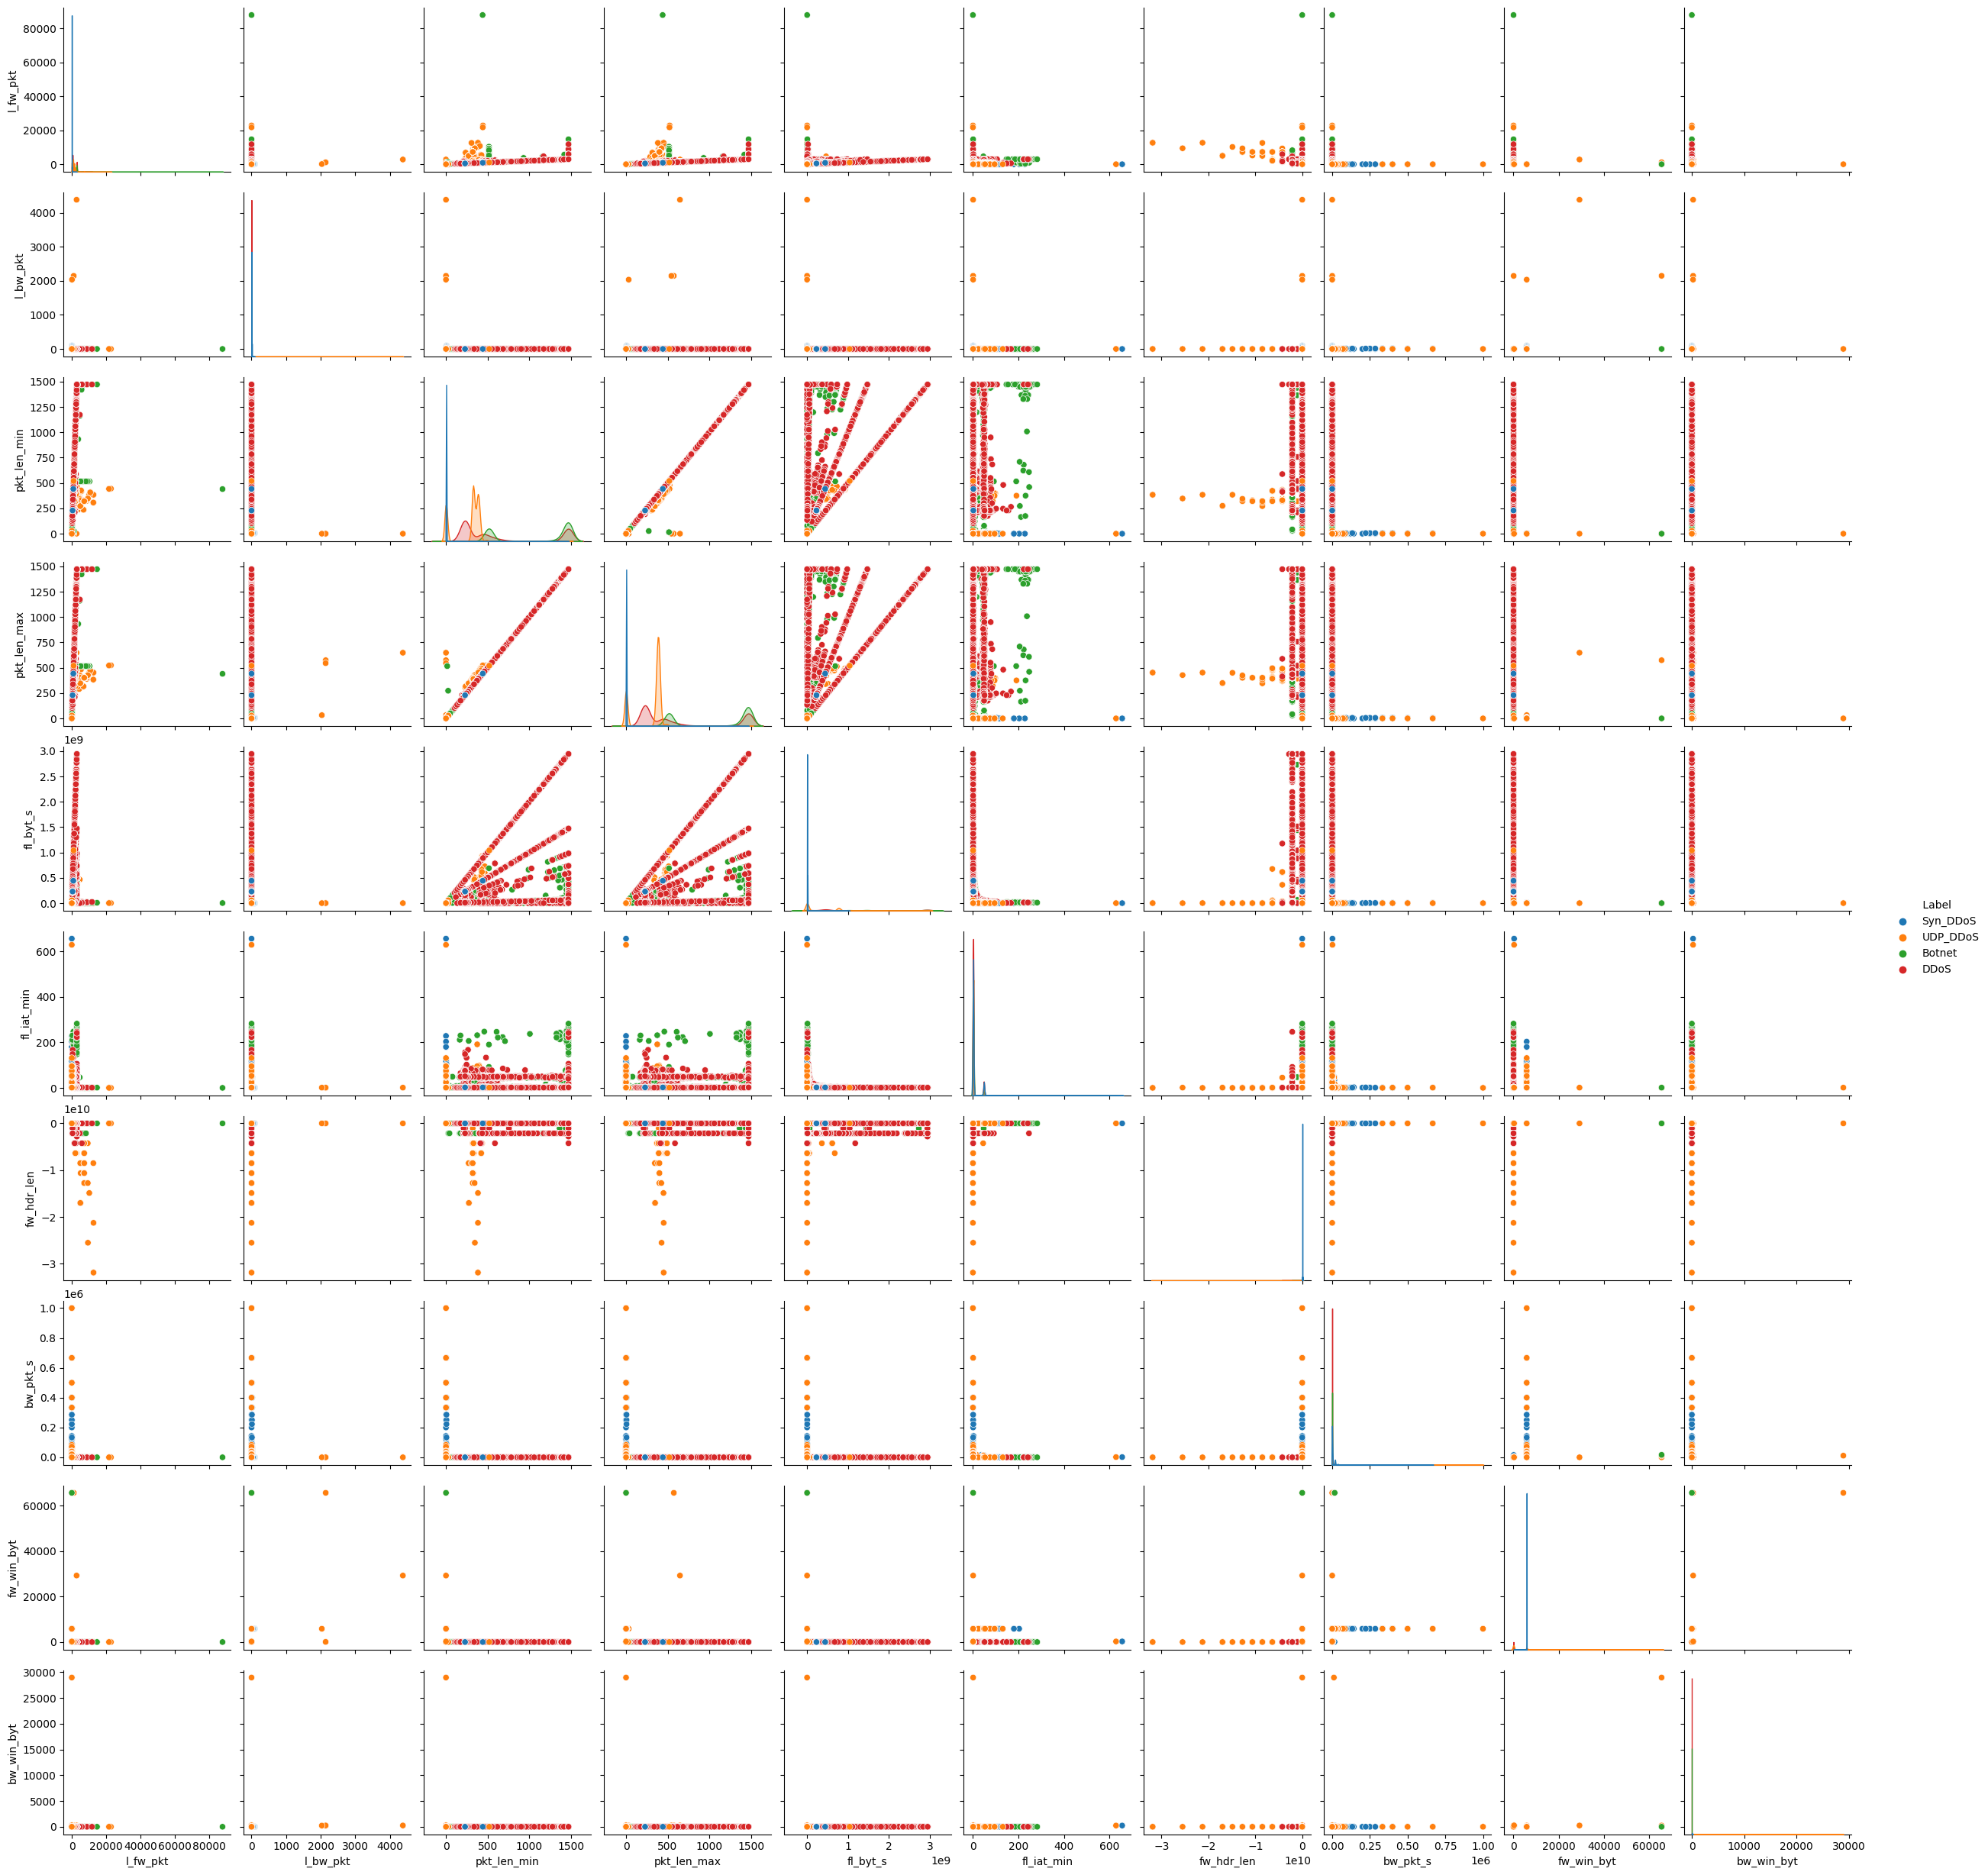

In [11]:
feat = df_con[['l_fw_pkt', 'l_bw_pkt', 'pkt_len_min', 'pkt_len_max', 'fl_byt_s', 'fl_iat_min', 'fw_hdr_len', 'bw_pkt_s', 'fw_win_byt', 'bw_win_byt',' Label']]
sns.pairplot(feat, hue = ' Label')
plt.show()

In [21]:
importance_ranking = pd.DataFrame({'Feature': X.columns, 'Selected': False})

for feature_idx in sfs.k_feature_idx_:
    importance_ranking.loc[feature_idx, 'Selected'] = True
    
importance_ranking.dropna()
print(importance_ranking.sort_values(by='Selected', ascending=False))


        Feature Selected
2   pkt_len_min     True
3   pkt_len_max     True
4      fl_byt_s     True
5    fl_iat_min     True
7      bw_pkt_s     True
8    fw_win_byt     True
11          NaN     True
12          NaN     True
14          NaN     True
15          NaN     True
0      l_fw_pkt    False
1      l_bw_pkt    False
6    fw_hdr_len    False
9    bw_win_byt    False


In [22]:
X.head()

,l_fw_pkt,l_bw_pkt,pkt_len_min,pkt_len_max,fl_byt_s,fl_iat_min,fw_hdr_len,bw_pkt_s,fw_win_byt,bw_win_byt
0,0.0,0.0,0.0,0.0,0.0,0.001527,1.0,0.0,0.089127,0.0
1,0.0,0.0,0.0,0.0,0.0,0.001527,1.0,0.0,0.089127,0.0
2,0.0,0.0,0.0,0.0,0.0,0.000000,1.0,0.0,0.089127,0.0
3,0.0,0.0,0.0,0.0,0.0,0.001527,1.0,0.0,0.089127,0.0
4,0.0,0.0,0.0,0.0,0.0,0.001527,1.0,0.0,0.089127,0.0


In [60]:
feat = df_con[['l_fw_pkt', 'l_bw_pkt', 'pkt_len_min', 'pkt_len_max', 'fl_byt_s', 'fl_iat_min', 'fw_hdr_len', 'bw_pkt_s', 'fw_win_byt', 'bw_win_byt',' Label']]
fea = feat.drop(columns = ' Label')

In [62]:
from sklearn import tree
cl = ['Botnet', 'DDoS']
sel = feat[feat[' Label'].isin(cl)]
clf = tree.DecisionTreeClassifier(random_state=0)
clf.fit(X, y_encoded)

DecisionTreeClassifier(random_state=0)

In [63]:
from sklearn.tree import export_text
dot_data = export_text(clf, feature_names=fea.columns.tolist())
from sklearn.tree import export_graphviz
import graphviz

# Export the decision tree to a DOT file
dot_file = 'sat_tree.dot'
export_graphviz(clf, out_file=dot_file, feature_names=fea.columns.tolist(), class_names=sel[' Label'], filled=True, rounded=True)

# Render the decision tree to a PNG file
graph = graphviz.Source.from_file(dot_file)
graph.render('sat_tree')

'sat_tree.pdf'

In [55]:
from sklearn.model_selection import train_test_split
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, GRU
from tensorflow.keras.optimizers import Adam
from sklearn.preprocessing import OneHotEncoder



# One-hot encode the labels
onehot_encoder = OneHotEncoder(sparse=False)
y_encoded_onehot = onehot_encoder.fit_transform(y_encoded.reshape(-1, 1))

# GRU Model
model = Sequential()

model = Sequential()
model.add(GRU(50, input_shape=(10, 1), return_sequences=True))  # GRU input layer with 10 time steps and 1 feature
model.add(GRU(50, return_sequences=True))  # First hidden GRU layer
model.add(GRU(50, return_sequences=True))  # Second hidden GRU layer
model.add(GRU(50))  # Third hidden GRU layer
model.add(Dense(y_encoded_onehot.shape[1], activation='softmax'))  # Output layer


# Compile the model
model.compile(loss='categorical_crossentropy', optimizer=Adam(), metrics=['accuracy'])

# Split data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y_encoded_onehot, test_size=0.2, random_state=42)

# Train the model
model.fit(X_train, y_train, epochs=10, batch_size=32)

# Evaluate the model
loss, accuracy = model.evaluate(X_test, y_test)
print(f'Loss: {loss:.4f}, Accuracy: {accuracy:.4f}')


/opt/conda/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


Epoch 1/10
5240/5240 [==============================] - 57s 10ms/step - loss: 0.4626 - accuracy: 0.7920
Epoch 2/10
5240/5240 [==============================] - 50s 10ms/step - loss: 0.3998 - accuracy: 0.8210
Epoch 3/10
5240/5240 [==============================] - 51s 10ms/step - loss: 0.3899 - accuracy: 0.8257
Epoch 4/10
5240/5240 [==============================] - 50s 10ms/step - loss: 0.3802 - accuracy: 0.8284
Epoch 5/10
5240/5240 [==============================] - 44s 8ms/step - loss: 0.3785 - accuracy: 0.8300
Epoch 6/10
5240/5240 [==============================] - 42s 8ms/step - loss: 0.3770 - accuracy: 0.8297
Epoch 7/10
5240/5240 [==============================] - 41s 8ms/step - loss: 0.3708 - accuracy: 0.8307
Epoch 8/10
5240/5240 [==============================] - 41s 8ms/step - loss: 0.3738 - accuracy: 0.8302
Epoch 9/10
5240/5240 [==============================] - 41s 8ms/step - loss: 0.3711 - accuracy: 0.8310
Epoch 10/10
1310/1310 [==============================] - 7s 4ms/step 

In [5]:
model.save('model.keras')

Epoch 1/10
5240/5240 [==============================] - 48s 9ms/step - loss: 0.3654 - accuracy: 0.8332 - val_loss: 0.3481 - val_accuracy: 0.8400
Epoch 2/10
5240/5240 [==============================] - 50s 10ms/step - loss: 0.3609 - accuracy: 0.8340 - val_loss: 0.3772 - val_accuracy: 0.8329
Epoch 3/10
5240/5240 [==============================] - 49s 9ms/step - loss: 0.3597 - accuracy: 0.8352 - val_loss: 0.3554 - val_accuracy: 0.8391
Epoch 4/10
5240/5240 [==============================] - 48s 9ms/step - loss: 0.3583 - accuracy: 0.8352 - val_loss: 0.3601 - val_accuracy: 0.8362
Epoch 5/10
5240/5240 [==============================] - 48s 9ms/step - loss: 0.3574 - accuracy: 0.8357 - val_loss: 0.3436 - val_accuracy: 0.8409
Epoch 6/10
5240/5240 [==============================] - 47s 9ms/step - loss: 0.3553 - accuracy: 0.8370 - val_loss: 0.4079 - val_accuracy: 0.8117
Epoch 7/10
5240/5240 [==============================] - 46s 9ms/step - loss: 0.3541 - accuracy: 0.8365 - val_loss: 0.3455 - val_a

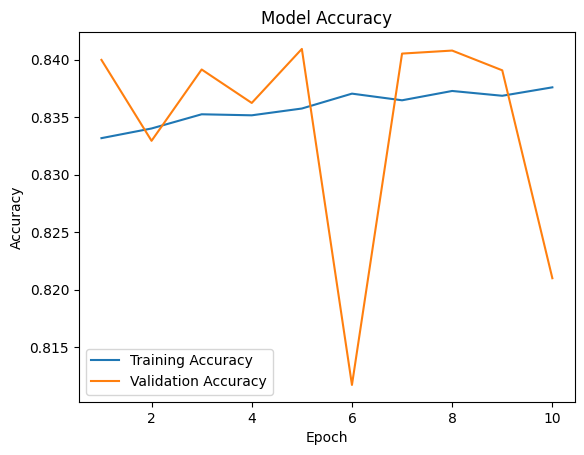

In [56]:
import matplotlib.pyplot as plt

history = model.fit(X_train, y_train, epochs=10, validation_data=(X_test, y_test))

train_accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']


plt.plot(range(1, len(train_accuracy) + 1), train_accuracy, label='Training Accuracy')
plt.plot(range(1, len(val_accuracy) + 1), val_accuracy, label='Validation Accuracy')


plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Model Accuracy')
plt.legend()

In [57]:
plt.show()

# WHITEBOX ATTACK 

In [5]:
# choosing a random sample from test data

X_test[22630:22631]

,l_fw_pkt,l_bw_pkt,pkt_len_min,pkt_len_max,fl_byt_s,fl_iat_min,fw_hdr_len,bw_pkt_s,fw_win_byt,bw_win_byt
1258,0.023455,0.0,0.350543,0.350543,2.336907e-07,0.071756,1.0,0.0,0.0,0.0


In [7]:
#predicting the label using trained model and actual prediction of the test data and comparing for validation

import numpy as np

if len(X_test) > 0 and len(y_encoded) > 0:
    single_data_point = X_test[22630:22631].values  # Convert DataFrame to a NumPy array and select the first data point
    single_label = y_encoded[22630:22631]  # Select the first label from y_encoded

    # Reshape the data point to match the model's input shape
    input_sample = single_data_point.reshape(1, 10, 1)

    # Make predictions on the single input using the model
    predictions = model.predict(input_sample)

    # Decode the predicted class label using one-hot encoding
    predicted_class = np.argmax(predictions)

    # If you have class labels as strings, use the label_encoder to decode the prediction
    predicted_label = label_encoder.inverse_transform([predicted_class])

    actual_class = np.argmax(single_label)
    actual_label = label_encoder.inverse_transform([actual_class])

    print("Actual Label:", actual_label)
    print("Predicted Label:", predicted_label[0])
else:
    print("X_test and y_encoded arrays are empty.")


1/1 [==============================] - 0s 21ms/step
Actual Label: ['Botnet']
Predicted Label: Botnet


In [15]:
X_test[22630:22631]

,l_fw_pkt,l_bw_pkt,pkt_len_min,pkt_len_max,fl_byt_s,fl_iat_min,fw_hdr_len,bw_pkt_s,fw_win_byt,bw_win_byt
1258,0.023455,0.0,0.001,0.350543,2.336907e-07,0.001,1.0,0.0,0.001,0.003


In [62]:

row_index = 22630

#new_values = [0.023455,0.0,0.350543,0.350543,2.336907e-07,0.071756,1.0,0.0,0.0,0.0]  # actual value in dataset
new_values = [2,2,2,2] #modified value in dataset

# copy of row to be modified
modified_row = X_test.iloc[row_index].copy()

# Updating features
#modified_row[['l_fw_pkt','l_bw_pkt','pkt_len_min','pkt_len_max','fl_byt_s','fl_iat_min','fw_hdr_len','bw_pkt_s','fw_win_byt','bw_win_byt']] = new_values
modified_row[['fw_win_byt','pkt_len_min','fl_iat_min','bw_win_byt']] = new_values

X_test.iloc[row_index] = modified_row


In [63]:
# X_test DataFrame with new values
X_test[22630:22631]

,l_fw_pkt,l_bw_pkt,pkt_len_min,pkt_len_max,fl_byt_s,fl_iat_min,fw_hdr_len,bw_pkt_s,fw_win_byt,bw_win_byt
1258,0.023455,0.0,2.0,0.350543,2.336907e-07,2.0,1.0,0.0,2.0,2.0


In [64]:
# checking actual and predicted value after changing the input feature values

import numpy as np

if len(X_test) > 0 and len(y_encoded) > 0:
    single_data_point = X_test[22630:22631].values  
    single_label = y_encoded[22630:22631]  

    input_sample = single_data_point.reshape(1, 10, 1) #modifying shape for 10 features
    predictions = model.predict(input_sample)

    predicted_class = np.argmax(predictions)

    predicted_label = label_encoder.inverse_transform([predicted_class])

    actual_class = np.argmax(single_label)
    actual_label = label_encoder.inverse_transform([actual_class])

    print("Actual Label:", actual_label)
    print("Predicted Label:", predicted_label[0])
else:
    print("X_test and y_encoded arrays are empty.")


1/1 [==============================] - 0s 21ms/step
Actual Label: ['Botnet']
Predicted Label: DDoS


In [59]:
import joblib
joblib.dump(model, 'gru_model.joblib')

['gru_model.joblib']

# modifying the feature values in the whole dataset and then training to see how it affects the model performance



In [44]:
#integrating data cleaning, feature extraction, data preprocessing

import pandas as pd
from mlxtend.feature_selection import SequentialFeatureSelector as SFS
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import LabelEncoder

from sklearn.model_selection import train_test_split

import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam

# Data preparation
sat = pd.read_csv("../input/satellite-dataset/SAT20.csv")
ter = pd.read_csv("../input/terrestrial-data/TER20.csv")

frames = [sat, ter]
df_c = pd.concat(frames)
df_c.drop(columns='id', inplace=True)

print(df_c.head())
print(df_c.shape)

# sample the dataset for easier debugging
# df_concat = df_concat.sample(n=100)

# These columns give problems with NaNs after normalizing
df_c = df_c.drop(columns=['syn_cnt', 'urg_cnt', 'bw_psh_flag', 'fw_urg_flag', 'bw_urg_flag', 'fin_cnt', 'psh_cnt', 'ece_cnt', 'fw_byt_blk_avg', 'fw_pkt_blk_avg', 'fw_blk_rate_avg', 'bw_byt_blk_avg', 'bw_pkt_blk_avg', 'bw_blk_rate_avg'])
print(df_c.head())

# Minority removal (merge data)
labels = {
    'Syn_DDoS': 'Syn_DDoS',
    'UDP_DDoS': 'UDP_DDoS',
    'Botnet': 'Botnet',
    'Portmap_DDoS': 'DDoS',
    'Backdoor': 'Botnet',
    'Web Attack': 'Botnet',
    'LDAP_DDoS': 'DDoS',
    'MSSQL_DDoS': 'DDoS',
    'NetBIOS_DDoS': 'DDoS'
}
df_c[' Label'] = df_c[' Label'].map(labels)
print(df_c[' Label'].value_counts())

   fl_dur  fw_pk  l_fw_pkt  l_bw_pkt  pkt_len_min  pkt_len_max  pkt_len_std  \
0       1      2         0         0            0            0          0.0   
1       1      2         0         0            0            0          0.0   
2       0      2         0         0            0            0          0.0   
3       1      2         0         0            0            0          0.0   
4       1      2         0         0            0            0          0.0   

   fl_byt_s  fl_iat_min  bw_iat_tot  ...  down_up_ratio  fw_byt_blk_avg  \
0       0.0           1           0  ...              0               0   
1       0.0           1           0  ...              0               0   
2       0.0           0           0  ...              0               0   
3       0.0           1           0  ...              0               0   
4       0.0           1           0  ...              0               0   

   fw_pkt_blk_avg  fw_blk_rate_avg  bw_byt_blk_avg  bw_pkt_blk_avg  \
0   

In [45]:
df_c

,fl_dur,fw_pk,l_fw_pkt,l_bw_pkt,pkt_len_min,pkt_len_max,pkt_len_std,fl_byt_s,fl_iat_min,bw_iat_tot,bw_iat_min,fw_hdr_len,bw_pkt_s,down_up_ratio,fw_win_byt,bw_win_byt,Label
0,1,2,0,0,0,0,0.0,0.0,1,0,0,40,0.0,0,5840,-1,Syn_DDoS
1,1,2,0,0,0,0,0.0,0.0,1,0,0,40,0.0,0,5840,-1,Syn_DDoS
2,0,2,0,0,0,0,0.0,0.0,0,0,0,40,0.0,0,5840,-1,Syn_DDoS
3,1,2,0,0,0,0,0.0,0.0,1,0,0,40,0.0,0,5840,-1,Syn_DDoS
4,1,2,0,0,0,0,0.0,0.0,1,0,0,40,0.0,0,5840,-1,Syn_DDoS
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
127239,1,2,0,0,0,0,0.0,0.0,1,0,0,40,0.0,0,5840,-1,UDP_DDoS
127240,1,2,0,0,0,0,0.0,0.0,1,0,0,40,0.0,0,5840,-1,UDP_DDoS
127241,1,2,0,0,0,0,0.0,0.0,1,0,0,40,0.0,0,5840,-1,UDP_DDoS
127242,53,2,0,0,0,0,0.0,0.0,53,0,0,40,0.0,0,5840,-1,UDP_DDoS


In [46]:
import pandas as pd
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from mlxtend.feature_selection import SequentialFeatureSelector as SFS


#replacing values of 3 columns with 'fw_win_byt' value
df_c['pkt_len_min'] = df['fw_win_byt']
df_c['fl_iat_min']= df['fw_win_byt']
df_c['bw_win_byt']= df['fw_win_byt']

# Further preprocessing and model training

# Extract the label column
y1 = df_c[' Label']
df_c.drop(columns=' Label', inplace=True)
label_encoder = LabelEncoder()
y1_encoded = label_encoder.fit_transform(y1)

# copy of the DataFrame before normalization
df_c_copy = df_c.copy()

# Min-max normalization
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
df_c_copy[df_c.columns] = scaler.fit_transform(df_c_copy[df_c.columns])

X1 = df_c_copy 

# List of 10 feature names which RF-SFS selected
selected_feature_names = ['l_fw_pkt', 'l_bw_pkt', 'pkt_len_min', 'pkt_len_max', 'fl_byt_s', 'fl_iat_min', 'fw_hdr_len', 'bw_pkt_s', 'fw_win_byt', 'bw_win_byt']

X1 = X1[selected_feature_names]




In [47]:
# Altered values in the training data
X1.head()

,l_fw_pkt,l_bw_pkt,pkt_len_min,pkt_len_max,fl_byt_s,fl_iat_min,fw_hdr_len,bw_pkt_s,fw_win_byt,bw_win_byt
0,0.0,0.0,0.089127,0.0,0.0,0.001527,1.0,0.0,0.089127,0.0
1,0.0,0.0,0.089127,0.0,0.0,0.001527,1.0,0.0,0.089127,0.0
2,0.0,0.0,0.089127,0.0,0.0,0.000000,1.0,0.0,0.089127,0.0
3,0.0,0.0,0.089127,0.0,0.0,0.001527,1.0,0.0,0.089127,0.0
4,0.0,0.0,0.089127,0.0,0.0,0.001527,1.0,0.0,0.089127,0.0


In [49]:
#model training with poisoned data

from sklearn.model_selection import train_test_split
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, GRU
from tensorflow.keras.optimizers import Adam
from sklearn.preprocessing import OneHotEncoder



# One-hot encode the labels
onehot_encoder = OneHotEncoder(sparse=False)
y1_encoded_onehot = onehot_encoder.fit_transform(y1_encoded.reshape(-1, 1))

# GRU Model
model1 = Sequential()

model1 = Sequential()
model1.add(GRU(50, input_shape=(10, 1), return_sequences=True))  # GRU input layer with 10 time steps and 1 feature
model1.add(GRU(50, return_sequences=True))  # First hidden GRU layer
model1.add(GRU(50, return_sequences=True))  # Second hidden GRU layer
model1.add(GRU(50))  # Third hidden GRU layer
model1.add(Dense(y1_encoded_onehot.shape[1], activation='softmax'))  # Output layer


# Compile the model
model1.compile(loss='categorical_crossentropy', optimizer=Adam(), metrics=['accuracy'])

# Split data into train and test sets
X1_train, X1_test, y1_train, y1_test = train_test_split(X1, y1_encoded_onehot, test_size=0.2, random_state=42)

# Train the model
model1.fit(X1_train, y1_train, epochs=10, batch_size=32)

# Evaluate the model
loss, accuracy = model1.evaluate(X1_test, y1_test)
print(f'Loss: {loss:.4f}, Accuracy: {accuracy:.4f}')


/opt/conda/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


Epoch 1/10
5240/5240 [==============================] - 50s 8ms/step - loss: nan - accuracy: 0.1930
Epoch 2/10
5240/5240 [==============================] - 42s 8ms/step - loss: nan - accuracy: 0.1930
Epoch 3/10
5240/5240 [==============================] - 42s 8ms/step - loss: nan - accuracy: 0.1930
Epoch 4/10
5240/5240 [==============================] - 41s 8ms/step - loss: nan - accuracy: 0.1930
Epoch 5/10
5240/5240 [==============================] - 42s 8ms/step - loss: nan - accuracy: 0.1930
Epoch 6/10
5240/5240 [==============================] - 43s 8ms/step - loss: nan - accuracy: 0.1930
Epoch 7/10
5240/5240 [==============================] - 41s 8ms/step - loss: nan - accuracy: 0.1930
Epoch 8/10
5240/5240 [==============================] - 41s 8ms/step - loss: nan - accuracy: 0.1930
Epoch 9/10
5240/5240 [==============================] - 42s 8ms/step - loss: nan - accuracy: 0.1930
Epoch 10/10
1310/1310 [==============================] - 7s 4ms/step - loss: nan - accuracy: 0.1918


Epoch 1/10
5240/5240 [==============================] - 45s 9ms/step - loss: nan - accuracy: 0.1930 - val_loss: nan - val_accuracy: 0.1918
Epoch 2/10
5240/5240 [==============================] - 44s 8ms/step - loss: nan - accuracy: 0.1930 - val_loss: nan - val_accuracy: 0.1918
Epoch 3/10
5240/5240 [==============================] - 46s 9ms/step - loss: nan - accuracy: 0.1930 - val_loss: nan - val_accuracy: 0.1918
Epoch 4/10
5240/5240 [==============================] - 45s 9ms/step - loss: nan - accuracy: 0.1930 - val_loss: nan - val_accuracy: 0.1918
Epoch 5/10
5240/5240 [==============================] - 45s 9ms/step - loss: nan - accuracy: 0.1930 - val_loss: nan - val_accuracy: 0.1918
Epoch 6/10
5240/5240 [==============================] - 45s 9ms/step - loss: nan - accuracy: 0.1930 - val_loss: nan - val_accuracy: 0.1918
Epoch 7/10
5240/5240 [==============================] - 45s 9ms/step - loss: nan - accuracy: 0.1930 - val_loss: nan - val_accuracy: 0.1918
Epoch 8/10
5240/5240 [=====

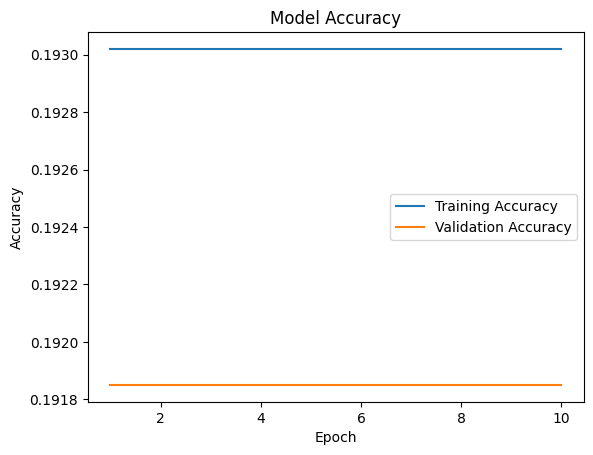

In [52]:
import matplotlib.pyplot as plt

history1 = model1.fit(X1_train, y1_train, epochs=10, validation_data=(X1_test, y1_test))

train_accuracy = history1.history['accuracy']
val_accuracy = history1.history['val_accuracy']


plt.plot(range(1, len(train_accuracy) + 1), train_accuracy, label='Training Accuracy')
plt.plot(range(1, len(val_accuracy) + 1), val_accuracy, label='Validation Accuracy')


plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Model Accuracy')
plt.legend()

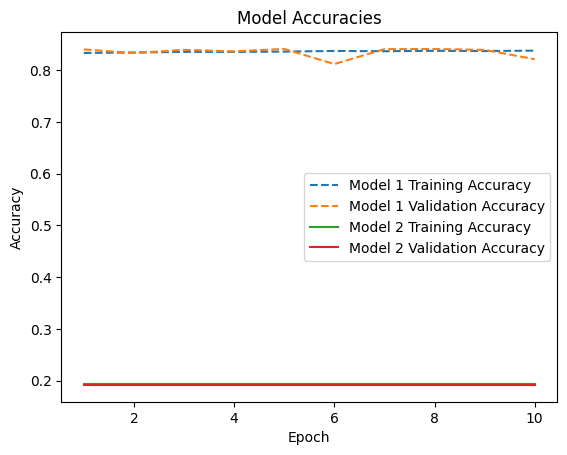

In [58]:
import matplotlib.pyplot as plt

# Assuming you have the training history of two models, model1_history and model2_history
# Each history object contains accuracy values for both training and validation

# Extract accuracy values from the first model's history
model1_train_accuracy = history.history['accuracy']
model1_val_accuracy = history.history['val_accuracy']

# Extract accuracy values from the second model's history
model2_train_accuracy = history1.history['accuracy']
model2_val_accuracy = history1.history['val_accuracy']

# Create a plot to visualize the training and validation accuracies of both models
plt.plot(range(1, len(model1_train_accuracy) + 1), model1_train_accuracy, label='Model 1 Training Accuracy', linestyle='--')
plt.plot(range(1, len(model1_val_accuracy) + 1), model1_val_accuracy, label='Model 1 Validation Accuracy', linestyle='--')
plt.plot(range(1, len(model2_train_accuracy) + 1), model2_train_accuracy, label='Model 2 Training Accuracy')
plt.plot(range(1, len(model2_val_accuracy) + 1), model2_val_accuracy, label='Model 2 Validation Accuracy')

# Add labels and a legend
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Model Accuracies')
plt.legend()

# Show the plot
plt.show()
